# Wildfire Detection Threshold Model

author : Camen Piho  
last run : Dec 26, 2019

In [81]:
from collections import namedtuple
import datetime

import matplotlib.pyplot as plt
import numpy as np

from wildfire.goes import downloader, utilities

## Introduction

Xu Zhong, an IBM researcher, set up a threshold model to detect wildfires in Australia using the Himawari-8 satellite. It is discussed [in this paper](https://www.researchgate.net/publication/318455389_Real-time_wildfire_detection_and_tracking_in_Australia_using_geostationary_satellite_Himawari-8) and this notebook provides an implementation of their model using GOES-R satellite data to detect wildfires in the United States.

## Data

In [92]:
GoesScan = namedtuple("GoesScan", ("band_2", "band_3", "band_6", "band_7", "band_14", "band_15"))
CHANNELS = [2, 3, 6, 7, 14, 15]


def get_scan(satellite, region, scan_time_utc):
    s3_paths = s3_object_summaries=downloader.query_s3(
            satellite=satellite, 
            regions=[region], 
            channels=CHANNELS,
            start=scan_time_utc, 
            end=scan_time_utc + datetime.timedelta(minutes=1)
        )
    
    if len(s3_paths) != len(CHANNELS):
        raise ValueError(f"Got {len(s3_paths)} paths, should be {len(CHANNELS)}")
    
    scans_dict = {}
    for s3_path in s3_paths:
        _, channel, _, _ = utilities.parse_filename(s3_path.key)
        s3_url = f"s3://{s3_path.bucket_name}/{s3_path.key}"
        scans_dict[channel] = downloader.read_s3(
            s3_bucket=s3_path.bucket_name, s3_key=s3_path.key
        )
    return GoesScan(
        band_2=scans_dict[2],
        band_3=scans_dict[3],
        band_6=scans_dict[6],
        band_7=scans_dict[7],
        band_14=scans_dict[14],
        band_15=scans_dict[15],
    )


def normalize(sample):
    sample_mean = sample.mean()
    sample_sd = sample.std()
    return (sample - sample_mean) / sample_sd

In [93]:
goes_scan_1 = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 27, 20, 0))
goes_scan_2 = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 10, 20, 0))
goes_scan_3 = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 11, 1, 18, 0))

## is not cloud

In [77]:
def is_not_cloud_1(band_2, band_3, band_15):
    band_2 = band_2.dataset.reflectance_factor.data[::4, ::4]
    band_3 = band_3.dataset.reflectance_factor.data[::2, ::2]
    band_15 = band_15.dataset.brightness_temperature.data
    return (
        ((band_2 + band_3) < 1.2) 
    )

def is_not_cloud_2(band_2, band_3, band_15):
    band_2 = band_2.dataset.reflectance_factor.data[::4, ::4]
    band_3 = band_3.dataset.reflectance_factor.data[::2, ::2]
    band_15 = band_15.dataset.brightness_temperature.data
    return (
        (band_15 > 265)
    )

def is_not_cloud_3(band_2, band_3, band_15):
    band_2 = band_2.dataset.reflectance_factor.data[::4, ::4]
    band_3 = band_3.dataset.reflectance_factor.data[::2, ::2]
    band_15 = band_15.dataset.brightness_temperature.data
    return (
        ((band_2 + band_3) < 0.5) | (band_15 > 285)
    )


def is_not_cloud(band_2, band_3, band_15):
    return (
        is_not_cloud_1(band_2, band_3, band_15) &
        is_not_cloud_2(band_2, band_3, band_15) & 
        is_not_cloud_3(band_2, band_3, band_15)
    )

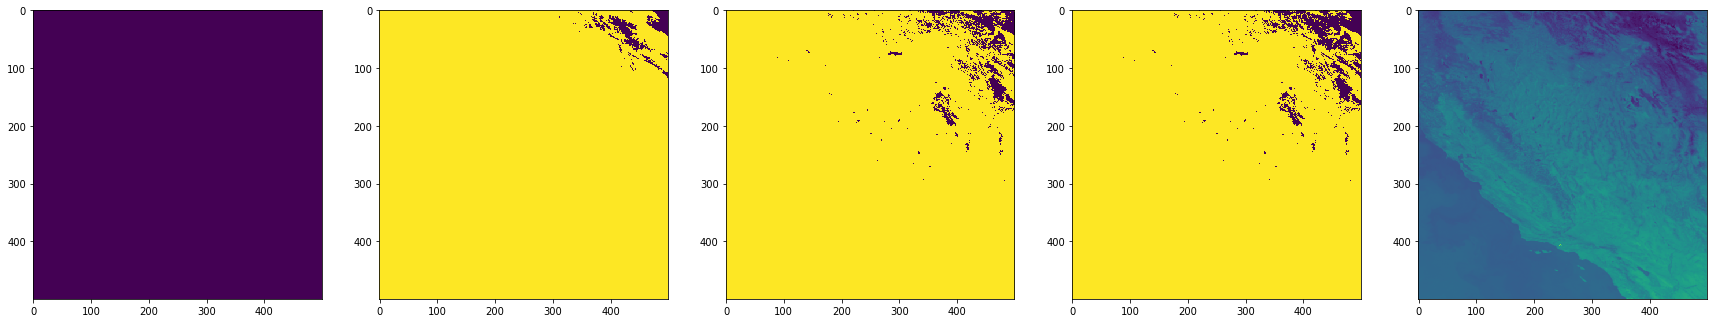

In [8]:
t = goes_scan_3

fig, axes = plt.subplots(ncols=5, figsize=(30, 20))
axes[0].imshow(is_not_cloud_1(t.band_2, t.band_3, t.band_15))
axes[1].imshow(is_not_cloud_2(t.band_2, t.band_3, t.band_15))
axes[2].imshow(is_not_cloud_3(t.band_2, t.band_3, t.band_15))
axes[3].imshow(
    is_not_cloud_1(t.band_2, t.band_3, t.band_15) &
    is_not_cloud_2(t.band_2, t.band_3, t.band_15) & 
    is_not_cloud_3(t.band_2, t.band_3, t.band_15)
)
axes[4].imshow(t.band_7.dataset.brightness_temperature);

## is not water

In [9]:
def is_not_water(band_6):
    return band_6.dataset.reflectance_factor.data > 0.03

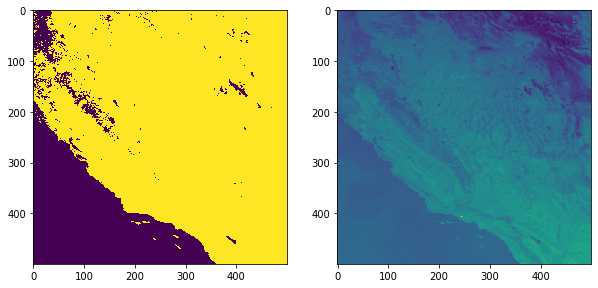

In [10]:
t = goes_scan_3

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(is_not_water(t.band_6))
axes[1].imshow(t.band_7.dataset.brightness_temperature);

## is night

few false positives at night, so if night we can skip filtering out water and cloud pixels

In [11]:
goes_scan_1_night = Scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 27, 10, 0))
goes_scan_2_night = Scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 10, 10, 0))
goes_scan_3_night = Scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 11, 1, 8, 0))

In [12]:
def is_night(band_2, band_3):
    return (
        (np.abs(band_2.dataset.reflectance_factor.data[::4, ::4]) < 0.008) | 
        (np.abs(band_3.dataset.reflectance_factor.data[::2, ::2]) < 0.008)
    )

8.4e-05


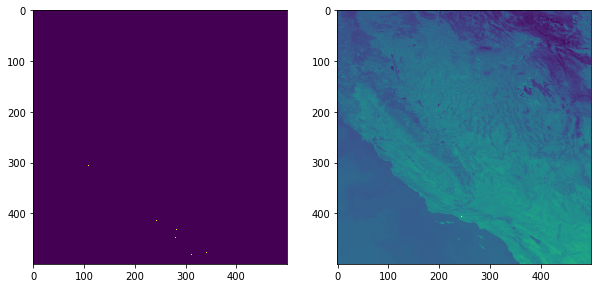

In [13]:
t = goes_scan_3

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
night = is_night(t.band_2, t.band_3)
print(night.mean())
axes[0].imshow(night)
axes[1].imshow(t.band_7.dataset.brightness_temperature);

## is hot

In [52]:
def is_hot(band_7, band_14):
    return (
        (normalize(band_7.dataset.brightness_temperature.data) > 2) & 
        (normalize(band_7.dataset.brightness_temperature.data - band_14.dataset.brightness_temperature.data) > 3)
    )

In [15]:
# might miss something in 1 night
# false positive in scan 3?

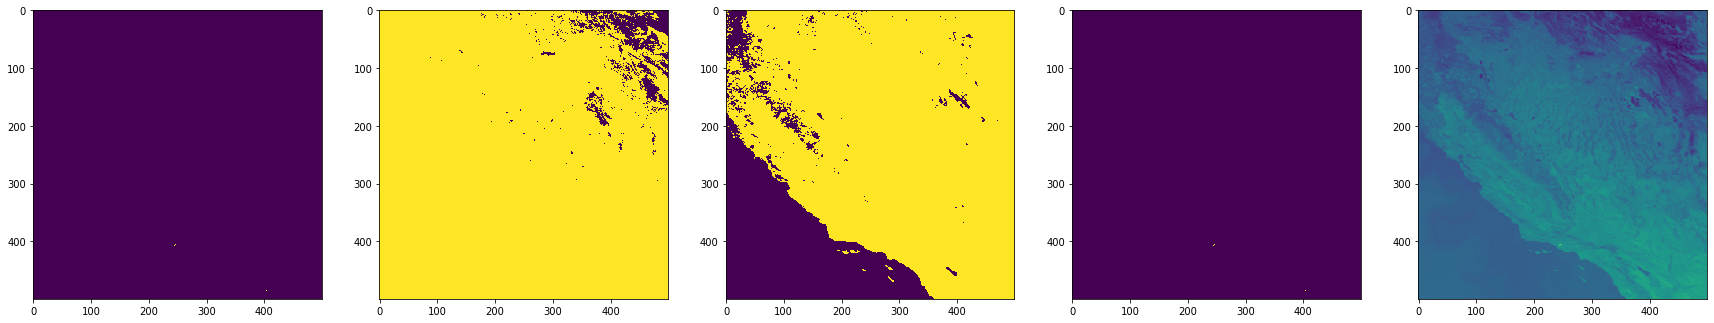

In [54]:
t = goes_scan_3

fig, axes = plt.subplots(ncols=5, figsize=(30, 20))
axes[0].imshow(is_hot(t.band_7, t.band_14))
axes[1].imshow(
    is_not_cloud(t.band_2, t.band_3, t.band_15)
)
axes[2].imshow(
    is_not_water(t.band_6)
)
axes[3].imshow(
    is_hot(t.band_7, t.band_14) & 
    (
        is_night(t.band_2, t.band_3) |
        (
            is_not_cloud(t.band_2, t.band_3, t.band_15) &
            is_not_water(t.band_6)
        )
    )
)
axes[4].imshow(t.band_7.dataset.brightness_temperature);

## algorithm

is_hot()? -> false -> end  
is_hot()? -> true -> is_night()? -> true -> end  
is_hot()? -> true -> is_night()? -> false -> is_not_cloud()? and is_not_water? -> end

## when do we first name something a wildfire?

In [73]:
def is_fire(g_scan):
    return (
        is_hot(g_scan.band_7, g_scan.band_14) & 
        (
            is_night(g_scan.band_2, g_scan.band_3) |
            (
                is_not_cloud(g_scan.band_2, g_scan.band_3, g_scan.band_15) &
                is_not_water(g_scan.band_6)
            )
        )
    )

def plot_wildfire(g_scan):
    fire = is_fire(g_scan)
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(fire)
    axes[1].imshow(g_scan.band_7.dataset.brightness_temperature)
    plt.title(f"{g_scan.band_7.dataset.time_coverage_start}\n{fire.mean() > 0}")
    plt.show()
    plt.close();

In [19]:
def get_date_range(satellite, region, start, end):
    current = start
    scans = []
    while current <= end:
        print(current)
        scans.append(Scan(satellite, region, current))
        current += datetime.timedelta(hours=24)
    return scans

In [ ]:
goes_scans_1 = get_date_range("noaa-goes17", "M1", datetime.datetime(2019, 10, 18, 20, 0), datetime.datetime(2019, 11, 10, 20, 0))

In [61]:
goes_scans_3 = get_date_range("noaa-goes17", "M1", datetime.datetime(2019, 9, 30, 20, 0), datetime.datetime(2019, 10, 15, 10, 0))

2019-09-30 20:00:00
2019-10-01 20:00:00
2019-10-02 20:00:00
got 0 paths, should be 6
2019-10-03 20:00:00
2019-10-04 20:00:00
2019-10-05 20:00:00
2019-10-06 20:00:00
2019-10-07 20:00:00
2019-10-08 20:00:00
2019-10-09 20:00:00
2019-10-10 20:00:00
2019-10-11 20:00:00
2019-10-12 20:00:00
2019-10-13 20:00:00
2019-10-14 20:00:00


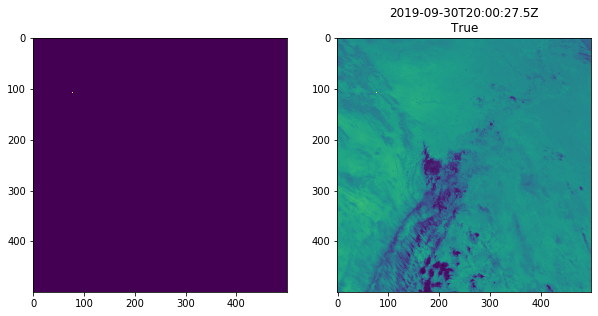

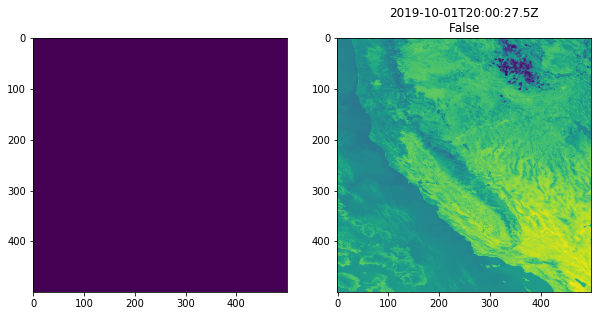

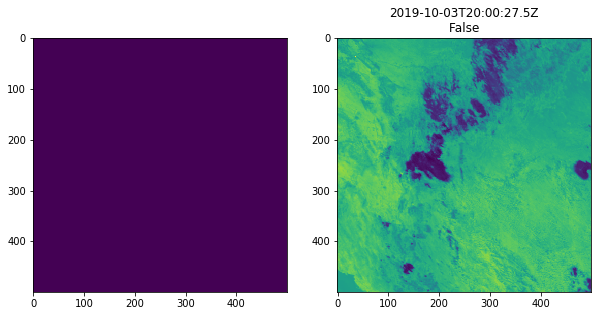

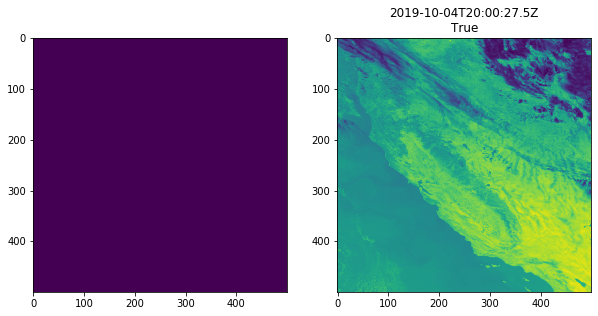

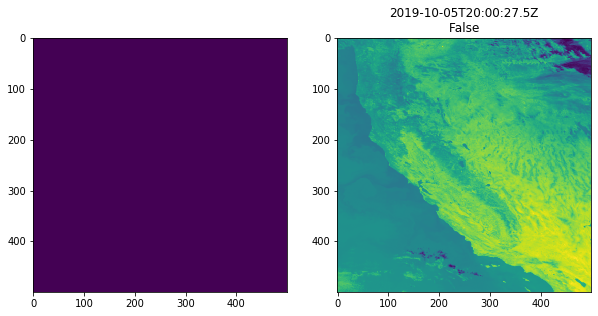

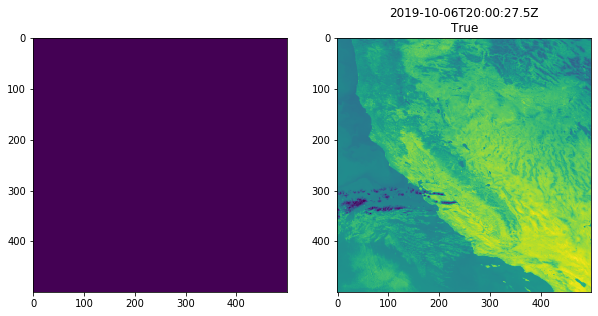

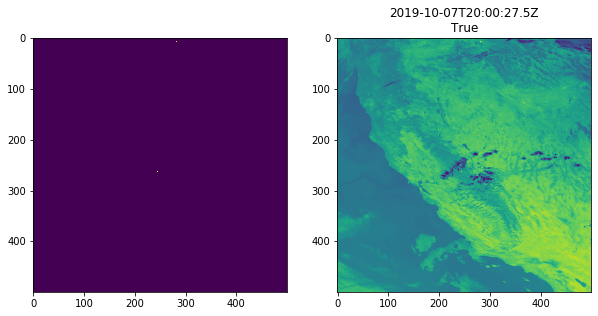

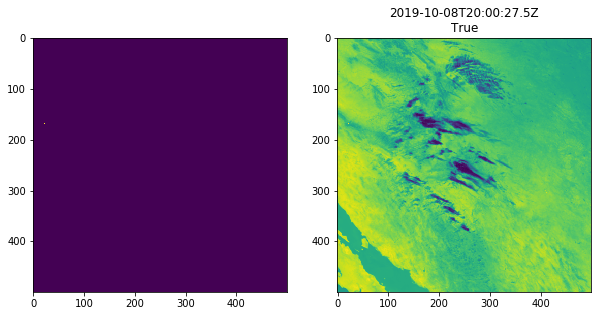

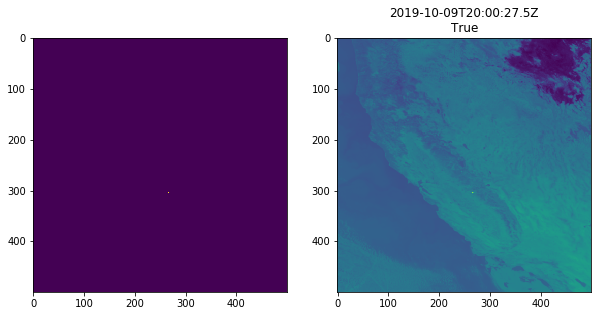

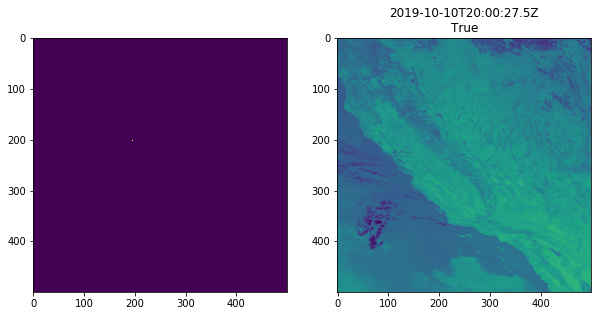

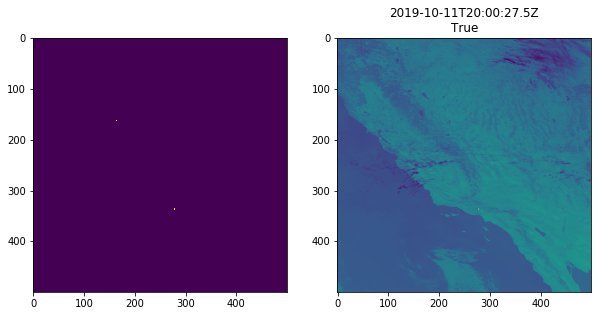

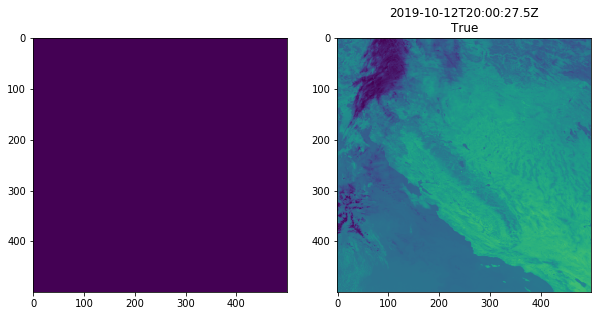

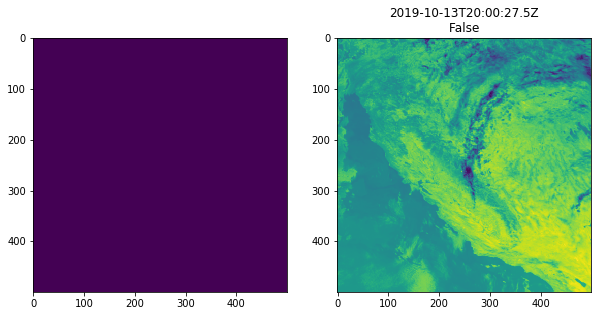

/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/i

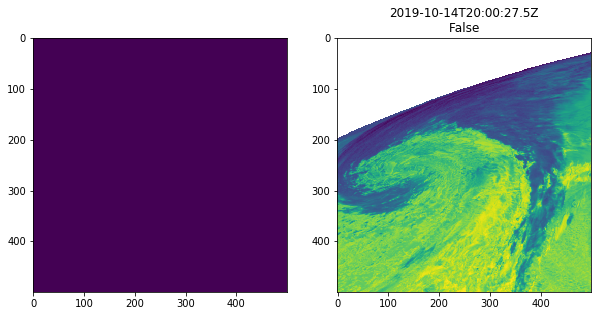

In [79]:
scans = goes_scans_3

for goes_scan in scans:
    try:
        plot_wildfire(goes_scan)
    except:
        continue